**The goal of the following document is to prepare images of lily slices for the thickness measurement step. There are three tepals located on each image that need to be separated into individual images in order to isolate them for thickness measurement. Furthermore, there is also a scale bar located on each image that needs to be removed in order to prevent potential interference with the thickness measuring algorithm.**

First, we place an example image somewhere in our drive to acess it in Google Colaboratory. We then read the image file, convert to ubyte so it has values between 0 and 255, and save it into a local variable (im). We'll plot the image to show that we correctly extracted it from drive.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import rescale
from skimage.util import img_as_ubyte

In [2]:
from google.colab import drive    # Code required to access files in google drive

drive.mount('/content/drive', force_remount=True)   # Mount google drive in order to access files

Mounted at /content/drive


(-0.5, 1599.5, 1199.5, -0.5)

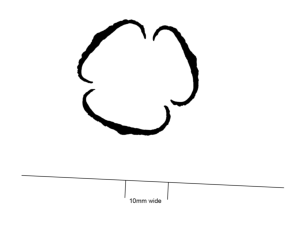

In [3]:
im = img_as_ubyte(plt.imread('/content/drive/MyDrive/LilyData/lilymask.jpeg'))

plt.imshow(im, cmap='gray')
plt.axis('off')

Next, we need to get rid of the scale bar and text in order to isolate the tepals. This is achieved pretty easily by using the `closing` (or the `opening` function if you invert first) function from `skimage.morphology`.

In [4]:
from skimage.morphology import disk, square, diamond
from skimage.morphology import opening, closing

(-0.5, 1599.5, 1199.5, -0.5)

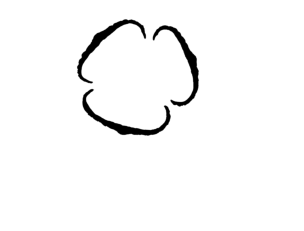

In [5]:
im_teps = closing(im, disk(4))
# im_teps2 = np.invert(opening(np.invert(im), disk(4)))


plt.imshow(im_teps, cmap='gray')
plt.axis('off')

Since the `closing` function may have altered the tepals (and our ability to take accurate thickness measurements!), we need to make sure they haven't changed too much, so let's test this out with both a `np.logical_xor` operation and difference between the original and tepals-only images.

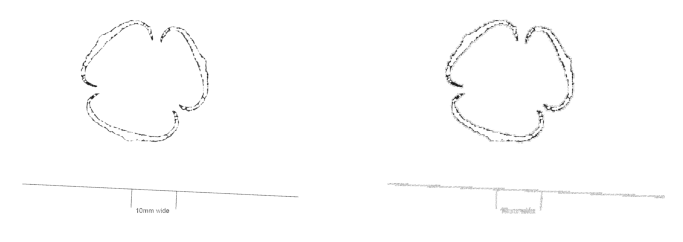

In [6]:
test = np.invert(np.logical_xor(im, im_teps))
test2 = np.invert(im - im_teps)

fig, ax = plt.subplots(ncols=2, figsize=(12,5))

ax[0].imshow(test, cmap='gray')
ax[1].imshow(test2, cmap='gray')

for axi in ax:
  axi.axis('off')

That's definitely going to be an issue. In order to solve this, we can dilate the tepals-only image, `im_teps`, by a large enough value that it overlaps the actual tepal sizes completely, and then use the `np.logical_and` operation to only extract the actual tepal sizes from the original image.

In [7]:
from skimage.util import img_as_bool
from skimage.morphology import dilation as dilate
from skimage.morphology import erosion as erode

(-0.5, 1599.5, 1199.5, -0.5)

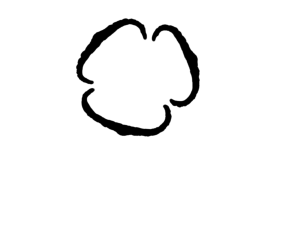

In [8]:
im2 = erode(im_teps, disk(5))

plt.imshow(im2, cmap='gray')
plt.axis('off')

Note: the `np.logical_and` only works if you're comparing two images with black backgrounds, rather than white backgrounds. Otherwise, any overlap with true and false values will get to set to false (which is still black on a white background) and not reflect your intentions with the and statement. This is easily fixed by inverting the images with `np.invert` before using the `np.logical_and` operation.

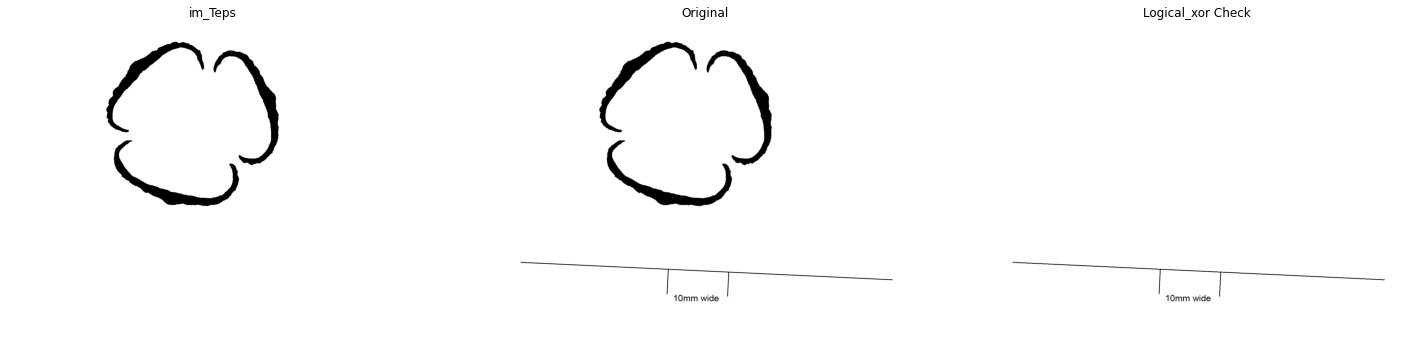

In [9]:
im_bool = img_as_bool(im)
im_Teps = np.invert(np.logical_and(np.invert(im_bool), np.invert(erode(im_teps, disk(7)))))

# Show images and retest with logical_xor
fig, ax = plt.subplots(ncols=3, figsize=(25,6))
titles = ['im_Teps', 'Original', 'Logical_xor Check', 'boop']

ax[0].imshow(im_Teps, cmap='gray')
ax[1].imshow(im, cmap='gray')
ax[2].imshow(np.invert(np.logical_xor(im_Teps, im_bool)), cmap='gray')

for i, axi in enumerate(ax):
  axi.axis('off')
  axi.set_title(titles[i])

Success!!!

Next, we need to isolate each tepal into its own separate image. We can do this by using the `label` function in the `scipy.ndimage` module.

In [10]:
from scipy.ndimage import label

(-0.5, 1599.5, 1199.5, -0.5)

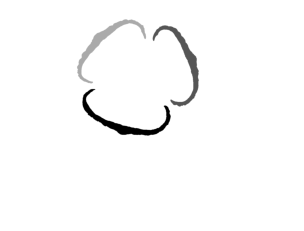

In [11]:
label_tepals, _ = label(1 - im_Teps)

plt.imshow(1 - label_tepals, cmap="gray")
plt.axis('off')

Finally, we need to separate the tepals into their own images. To do this, we can again use logical operators. Since the labels are defined using integers, we can use the `np.logical_and` operator again with three images of just 2s, 3s, or 4s, since the 1s constitute the background!

In [12]:
# Generate 2x2 arrays with the size of label_tepals containing all 2s, 3s, or 4s
twos = 2*np.ones(np.shape(label_tepals))
threes = 3*np.ones(np.shape(label_tepals))
fours = 4*np.ones(np.shape(label_tepals))

# Separate the 3 tepals into three individual images
#tepal_1 = np.logical_and(label_tepals, twos)
tepal_2 = np.logical_and(label_tepals, threes)
tepal_3 = np.logical_and(label_tepals, fours)

In [13]:
from skimage.measure import regionprops

In [60]:
tepals = []

for tepal in regionprops(label_tepals):
  crop = np.pad(tepal.image, np.round(0.05*len(tepal.image)).astype(int))
  tepals.append(crop)

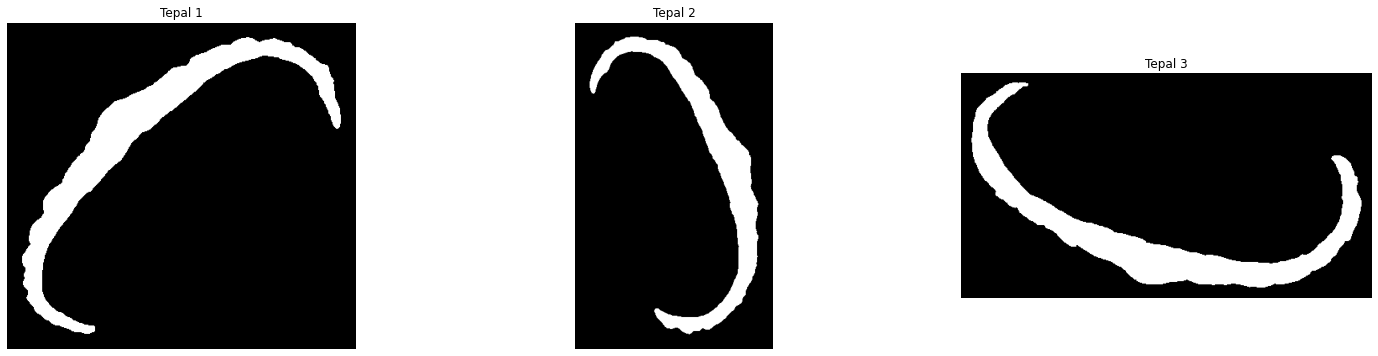

In [61]:
# Show individual tepals
fig, ax = plt.subplots(ncols=3, figsize=(25,6))
titles = ['Tepal 1', 'Tepal 2', 'Tepal 3']

ax[0].imshow(tepals[0], cmap='gray')
ax[1].imshow(tepals[1], cmap='gray')
ax[2].imshow(tepals[2], cmap='gray')

for i, axi in enumerate(ax):
  axi.axis('off')
  axi.set_title(titles[i])

Success!!